In [1]:
import sys
sys.path.insert(0, '../../')  

import math
import numpy as np
import matplotlib.pyplot as plt 
from gasp import train_gasp, run_gasp, simulate_ssfp, simulate_ssfp_simple, sampling, responses, SSFPParams

In [2]:
def compute_condition_number(I):
    I = I.reshape((-1, I.shape[-1]))    # Collapse all dimensions last dimension
    return np.linalg.cond(I)            # Compute condition number

def run_model(D, params):
    width = 256
    height = 1
    gradient = 2 * np.pi
    method = 'affine'
    T2base = 0.01
    T1T2ratio = 5

    M = simulate_ssfp_simple(width=width, height=height, T1=T1T2ratio * T2base, T2 = T2base, params=params, minTR = np.min(params.TRs), gradient = gradient)
    C = compute_condition_number(M)
    _, A = train_gasp(M, D, method=method)
    I = run_gasp(M, A, method=method)
    MSE = np.sqrt(np.mean((np.abs(I) - D)**2))

    return A, MSE, C

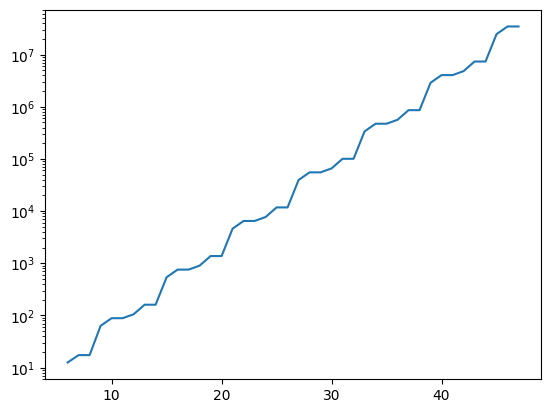

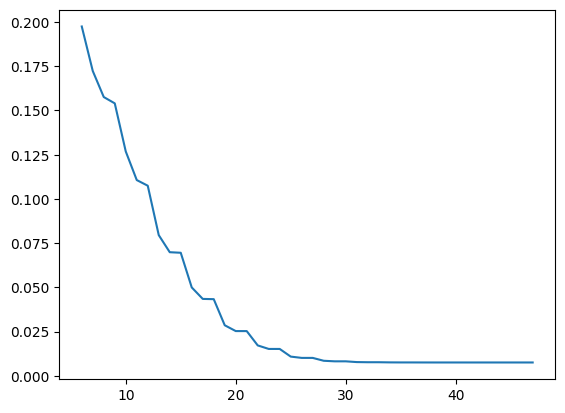

In [3]:
width = 256
alpha = np.deg2rad(20)
D = responses.bandpass_filter(width, bw=0.2, shift=0)

n_points = np.array(range(6,48))
C = np.zeros(len(n_points))
MSE = np.zeros(len(n_points))
for i, n in enumerate(n_points):
    TRs, PCs = sampling.grid_TR_sampling(n_points=n, TRs=[5e-3, 10e-3, 20e-3])
    params = SSFPParams(n, alpha, TRs, PCs)
    D = responses.gaussian(width, bw=0.2, shift=0)
    A, MSE[i], C[i] = run_model(D, params)

plt.semilogy(n_points, C)
plt.show()

plt.plot(n_points, MSE)
plt.show()


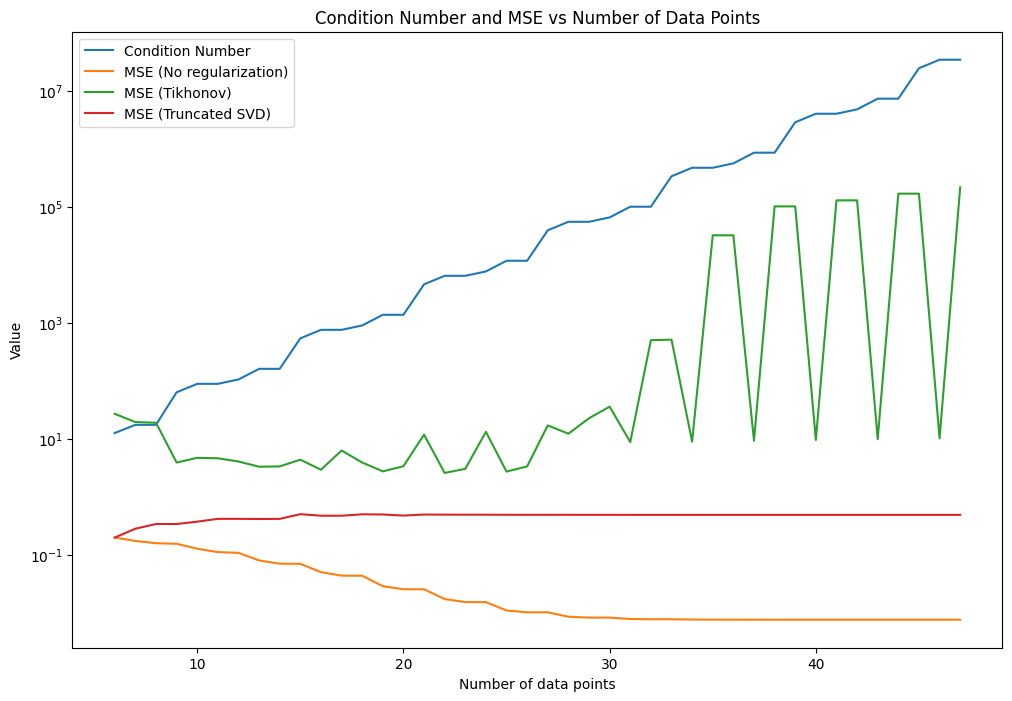

In [4]:
import numpy as np
import numpy.typing as npt
from scipy import linalg

def train_gasp(I: npt.NDArray, D: npt.NDArray, method: str = "affine", regularization: str = None, lambda_reg: float = 0.1):
    ''' Train GASP model on data with shape [Height, Width, PCs x TRs] and desired spectral profile D with shape [Width,]
    
    Parameters:
    I (NDArray): Array of phase-cycled images.
    D (NDArray): Vector of samples of desired spectral profile.
    method (str, optional): Method used to compute the GASP model solution.
        Must be one of {"affine", "linear", "lev-mar", "lev-mar-quad"}.
    regularization (str, optional): Regularization method to use.
        Must be one of {"tikhonov", "truncated_svd", None}.
    lambda_reg (float, optional): Regularization parameter for Tikhonov regularization.

    Returns:
    tuple: Reconstructed image and coefficients.
    '''

    # Reshape the data to be in the form [Height x Width, PCs x TRs]
    height, width = I.shape[:2]
    I = I.reshape((-1, I.shape[-1]))    # Collapse all dimensions last dimension
    npcs = I.shape[-1]

    # Repeat the desired spectral profile to match the number of PCs
    D = np.tile(D, (int(I.shape[0]/D.size),))

    # Add a column of ones for affine method
    if method == "affine":
        I = np.column_stack((np.ones(I.shape[0]), I))

    # Apply regularization
    if regularization == "tikhonov":
        # Tikhonov regularization
        A = np.linalg.inv(I.T @ I + lambda_reg * np.eye(I.shape[1])) @ I.T @ D
    elif regularization == "truncated_svd":
        # Truncated SVD
        U, s, Vt = np.linalg.svd(I, full_matrices=False)
        k = int(0.9 * len(s))  # Use 90% of singular values
        s_inv = np.zeros_like(s)
        s_inv[:k] = 1 / s[:k]
        A = Vt.T @ np.diag(s_inv) @ U.T @ D
    else:
        # No regularization, use standard least squares
        A = np.linalg.lstsq(I, D, rcond=None)[0]

    # Reconstruct the image from the coefficients
    out = I @ A
    out = out.reshape(height, width)

    return out, A

def compute_condition_number(I):
    I = I.reshape((-1, I.shape[-1]))    # Collapse all dimensions except last dimension
    return np.linalg.cond(I)            # Compute condition number

def run_model(D, params, regularization=None, lambda_reg=0.1):
    width = 256
    height = 1
    gradient = 2 * np.pi
    method = 'affine'
    T2base = 0.01
    T1T2ratio = 5

    M = simulate_ssfp_simple(width=width, height=height, T1=T1T2ratio * T2base, T2 = T2base, params=params, minTR = np.min(params.TRs), gradient = gradient)
    C = compute_condition_number(M)
    _, A = train_gasp(M, D, method=method, regularization=regularization, lambda_reg=lambda_reg)
    I = run_gasp(M, A, method=method)
    MSE = np.sqrt(np.mean((np.abs(I) - D)**2))

    return A, MSE, C

# Example usage
width = 256
alpha = np.deg2rad(20)
D = responses.bandpass_filter(width, bw=0.2, shift=0)

n_points = np.array(range(6,48))
C = np.zeros(len(n_points))
MSE = np.zeros(len(n_points))
MSE_tikhonov = np.zeros(len(n_points))
MSE_truncated_svd = np.zeros(len(n_points))

for i, n in enumerate(n_points):
    TRs, PCs = sampling.grid_TR_sampling(n_points=n, TRs=[5e-3, 10e-3, 20e-3])
    params = SSFPParams(n, alpha, TRs, PCs)
    D = responses.gaussian(width, bw=0.2, shift=0)
    
    # No regularization
    _, MSE[i], C[i] = run_model(D, params)
    
    # Tikhonov regularization
    _, MSE_tikhonov[i], _ = run_model(D, params, regularization="tikhonov", lambda_reg=0.1)
    
    # Truncated SVD
    _, MSE_truncated_svd[i], _ = run_model(D, params, regularization="truncated_svd")

# Plotting results
plt.figure(figsize=(12, 8))
plt.semilogy(n_points, C, label='Condition Number')
plt.plot(n_points, MSE, label='MSE (No regularization)')
plt.plot(n_points, MSE_tikhonov, label='MSE (Tikhonov)')
plt.plot(n_points, MSE_truncated_svd, label='MSE (Truncated SVD)')
plt.xlabel('Number of data points')
plt.ylabel('Value')
plt.title('Condition Number and MSE vs Number of Data Points')
plt.legend()
plt.show()

In [ ]:
def ShapeSensitivityAnalysis(D, T1 = 0.9, T2 = .05, alpha0 = 5, alpha1 = 90, Nx = 50, rMin = 0.5, rMax = 20, Nr = 60, regularization = 'None'):
    width = 256
    height = 1
    npcs = 16
    TRs = [5e-3, 10e-3, 20e-3]
    n_points = npcs * len(TRs)
    gradient = 2 * np.pi
    method = 'affine'
    Na = npcs * len(TRs) + 1
    Alpha = np.linspace(alpha0, alpha1, Nx)
    Alpha = np.deg2rad(Alpha)
    T1T2ratio = np.linspace(rMin, rMax, Nr)
    TRs, PCs = sampling.grid_TR_sampling(n_points=n_points, TRs=TRs)

    # Train
    A = np.zeros((Nx, Na), dtype=np.complex128)
    for i, alpha in enumerate(Alpha):
        params = SSFPParams(n_points, alpha, TRs, PCs)
        M = simulate_ssfp_simple(width=width, height=height, T1=T1, T2 =T2, params=params, minTR = np.min(params.TRs), gradient = gradient)
        Ic, An = train_gasp(M, D, method=method, regularization=regularization)
        A[i, :] = np.array(An)

    # Evaluate
    MSE_2D = np.zeros((Nx, Nr))
    for i, alpha_train in enumerate(Alpha):
        for j, ratio in enumerate(T1T2ratio):
            params = SSFPParams(n_points, alpha_train, TRs, PCs)
            M = simulate_ssfp_simple(width=width, height=height, T1=0.1*ratio, T2 =0.1, params=params, minTR = np.min(params.TRs), gradient = gradient)
            I = run_gasp(M, A[i,:], method=method)
            MSE_2D[i,j] = np.sqrt(np.mean((np.abs(I) - D)**2))

    MSE_1D = MSE_2D.mean(axis=1)
    
    return MSE_2D, MSE_1D, Alpha, T1T2ratio

In [ ]:
def plotContour_MSE(MSE):
    from matplotlib import cm, ticker
    
    levels= np.linspace(MSE[0].min(), MSE[0].max(), 10)

    y = np.rad2deg(MSE[2])
    x = MSE[3]
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots()
    cs = ax.contourf(X, Y, MSE[0], locator=ticker.LogLocator(), cmap=cm.PuBu_r)
    cbar = fig.colorbar(cs)
    plt.ylabel(r'$\alpha_{train}$')
    plt.xlabel(r'T1 T2 ratio')
    plt.show()